# Integrate resources to create a drug repurposing hetnet

In [1]:
import pandas
import seaborn

import hetio.hetnet
import hetio.readwrite
import hetio.stats

from utils import rawgit, obo_iri

import datetime
import time

In [2]:
# execution starts
starts = datetime.datetime.now()
print('starts at: {}'.format(starts))
start = time.time()

starts at: 2017-04-01 00:31:13.981152


## Define the metagraph and instantiate the graph

In [3]:
kind_to_abbev = {
    
    # metanodes
    'Compound': 'C',
    'Disease': 'D',
    'Gene': 'G',
    'Anatomy': 'A',
    'Symptom': 'S',
    'Side Effect': 'SE',
    'Pathway': 'PW',
    'Pharmacologic Class': 'PC',
    'Biological Process': 'BP',
    'Cellular Component': 'CC',
    'Molecular Function': 'MF',
    
    # metaedges
    'treats': 't',
#     'palliates': 'p',
    'binds': 'b',
    'expresses': 'e',
    'regulates': 'r',
    'upregulates': 'u',
    'downregulates': 'd',
    'interacts': 'i',
    'includes': 'i',
    'covaries': 'c',
    'regulates': 'r',
    'participates': 'p',
    'resembles': 'r',
    'associates': 'a',
    'localizes': 'l',
    'presents': 'p',
    'causes': 'c',
}

metaedge_tuples = [
    ('Compound', 'Disease', 'treats', 'both'),
#     ('Compound', 'Disease', 'palliates', 'both'),
    ('Compound', 'Gene', 'binds', 'both'),
    ('Compound', 'Gene', 'upregulates', 'both'),
    ('Compound', 'Gene', 'downregulates', 'both'),
    ('Compound', 'Compound', 'resembles', 'both'),
    ('Compound', 'Side Effect', 'causes', 'both'),
    ('Pharmacologic Class', 'Compound', 'includes', 'both'),
    ('Anatomy', 'Gene', 'expresses', 'both'),
    ('Anatomy', 'Gene', 'upregulates', 'both'),
    ('Anatomy', 'Gene', 'downregulates', 'both'),
    ('Gene', 'Gene', 'interacts', 'both'),
    ('Gene', 'Gene', 'covaries', 'both'),
    ('Gene', 'Gene', 'regulates', 'forward'),
    ('Gene', 'Pathway', 'participates', 'both'),
    ('Gene', 'Biological Process', 'participates', 'both'),
    ('Gene', 'Cellular Component', 'participates', 'both'),
    ('Gene', 'Molecular Function', 'participates', 'both'),
    ('Disease', 'Disease', 'resembles', 'both'),
    ('Disease', 'Gene', 'associates', 'both'),
    ('Disease', 'Gene', 'upregulates', 'both'),
    ('Disease', 'Gene', 'downregulates', 'both'),
    ('Disease', 'Anatomy', 'localizes', 'both'),
    ('Disease', 'Symptom', 'presents', 'both'),
]
metagraph = hetio.hetnet.MetaGraph.from_edge_tuples(metaedge_tuples, kind_to_abbev)
graph = hetio.hetnet.Graph(metagraph)

## Gene Nodes

In [4]:
commit = 'a7362748a34211e5df6f2d185bb3246279760546'
url = rawgit('dhimmel', 'entrez-gene', commit, 'data/genes-human.tsv')
gene_df = pandas.read_table(url)
gene_df = gene_df[gene_df.type_of_gene == 'protein-coding']
coding_genes = set(gene_df.GeneID)
gene_df.head(2)

,tax_id,GeneID,Symbol,chromosome,map_location,type_of_gene,description
0,9606,1,A1BG,19,19q13.4,protein-coding,alpha-1-B glycoprotein
1,9606,2,A2M,12,12p13.31,protein-coding,alpha-2-macroglobulin


In [5]:
for i, row in gene_df.iterrows():
    if row.type_of_gene != 'protein-coding':
        continue
    data = {
        'description': row['description'],
        'source': 'Entrez Gene',
        'url': 'http://identifiers.org/ncbigene/{}'.format(row.GeneID),
        'license': 'CC0 1.0',
    }
    if pandas.notnull(row['chromosome']):
        data['chromosome'] = row['chromosome']
    graph.add_node(kind = 'Gene', identifier=row.GeneID, name=row.Symbol, data=data)

## Disease Nodes

In [6]:
commit = '75050ea2d4f60e745d3f3578ae03560a2cc0e444'
url = rawgit('dhimmel', 'disease-ontology', commit, 'data/slim-terms.tsv')
disease_df = pandas.read_table(url)
disease_df.head(2)

,doid,name,source,pathophysiology
0,DOID:2531,hematologic cancer,DOcancerslim,neoplastic
1,DOID:1319,brain cancer,DOcancerslim,neoplastic


In [7]:
# add NLGY1-deficiency node
row = ['DOID:0060728', 'NGLY1 deficiency', 'NGLY1-SuLab', 'rare genetic disease']
disease_df.loc[len(disease_df)] = row
disease_df.loc[len(disease_df)-1]

doid                       DOID:0060728
name                   NGLY1 deficiency
source                      NGLY1-SuLab
pathophysiology    rare genetic disease
Name: 137, dtype: object

In [8]:
for i, row in disease_df.iterrows():
    data = {
        'source': 'Disease Ontology',
        'url': obo_iri(row.doid),
        'license': 'CC BY 3.0',
    }
    graph.add_node(kind='Disease', identifier=row.doid, name=row['name'], data=data)

## Compound Nodes

In [9]:
commit = '3e87872db5fca5ac427ce27464ab945c0ceb4ec6'
url = rawgit('dhimmel', 'drugbank', commit, 'data/drugbank-slim.tsv')
compound_df = pandas.read_table(url)
compound_df.head(2)

,drugbank_id,name,type,groups,atc_codes,categories,inchikey,inchi
0,DB00014,Goserelin,small molecule,approved,L02AE03,NaN,InChIKey=BLCLNMBMMGCOAS-URPVMXJPSA-N,InChI=1S/C59H84N18O14/c1-31(2)22-40(49(82)68-3...
1,DB00035,Desmopressin,small molecule,approved,H01BA02,Antidiuretic Agents|Hemostatics|Renal Agents,InChIKey=NFLWUMRGJYTJIN-NXBWRCJVSA-N,InChI=1S/C46H64N14O12S2/c47-35(62)15-14-29-40(...


In [10]:
for i, row in compound_df.iterrows():
    url = 'http://www.drugbank.ca/drugs/' + row.drugbank_id
    data = {
        'source': 'DrugBank',
        'inchikey': row.inchikey,
        'inchi': row.inchi, 'url': url,
        'license': 'CC BY-NC 4.0',
    }
    graph.add_node(kind='Compound', identifier=row.drugbank_id, name=row['name'], data=data)

## Anotomy nodes

In [11]:
commit = '134f23479186abba03ba340fc6dc90e16c781920'
url = rawgit('dhimmel', 'uberon', commit, 'data/hetio-slim.tsv')
uberon_df = pandas.read_table(url)
uberon_df.head(2)

,uberon_id,uberon_name,mesh_id,mesh_name,bto_id
0,UBERON:0000002,uterine cervix,D002584,Cervix Uteri,BTO:0001421
1,UBERON:0000004,nose,D009666,Nose,BTO:0000840


In [12]:
for i, row in uberon_df.iterrows():
    data = {
        'source': 'Uberon',
        'url': obo_iri(row['uberon_id']),
        'license': 'CC BY 3.0',
    }
    for xref in 'mesh_id', 'bto_id':
        if pandas.notnull(row[xref]):
            data[xref] = row[xref]
    graph.add_node(kind='Anatomy', identifier=row['uberon_id'], name=row['uberon_name'], data=data)

## Symptom Nodes

In [13]:
commit = 'a7036a37302973b15ab949aab4056d9bc062910e'
url = rawgit('dhimmel', 'mesh', commit, 'data/symptoms.tsv')
symptom_df = pandas.read_table(url)
symptom_df.head(2)

,mesh_id,mesh_name,in_hsdn
0,D000006,"Abdomen, Acute",1
1,D000270,Adie Syndrome,0


In [14]:
# add 11 NGLY1 symptoms not in hetnet
ngly1_sym_df = pandas.read_table('ngly1-data/ngly1-symptoms.tsv', header=None)
ngly1_sym_df.columns = ['mesh_id', 'mesh_name']
ngly1_sym_df['in_hsdn'] = str('0')
ngly1_sym_df['mesh_id'] = ngly1_sym_df['mesh_id'].apply(lambda x: x.split('MESH:')[1])
data = [symptom_df, ngly1_sym_df]
symptom_df = pandas.concat(data, ignore_index=True)
symptom_df.tail(15)

,mesh_id,mesh_name,in_hsdn
434,D065634,Cerebrospinal Fluid Leak,0
435,D065635,Benign Paroxysmal Positional Vertigo,0
436,D065906,Hyperlactatemia,0
437,D066190,Allesthesia,0
438,C562827,Alacrima,0
439,D008831,Microcephaly,0
440,D005317,IUGR (intrauterine growth restriction),0
441,D003320,Corneal Ulcer,0
442,D017043,Chalazions,0
443,D013285,Strabismus,0


In [15]:
for i, row in symptom_df.iterrows():
    url = 'http://identifiers.org/mesh/{}'.format(row.mesh_id)
    data = {
        'source': 'MeSH',
        'url': url,
        'license': 'CC0 1.0',
    }
    graph.add_node(kind='Symptom', identifier=row.mesh_id, name=row.mesh_name, data=data)

## Pathway Nodes and Edges

In [16]:
commit = '1bd2c68853e38297d20f8f885419ff81fc0608a8'
url = rawgit('dhimmel', 'pathways', commit, 'data/pathways.tsv')
pathway_df = pandas.read_table(url)
len(pathway_df)
#pathway_df = pathway_df.query("n_coding_genes > 1")
#source_map = {
#    'wikipathways': 'WikiPathways',
#    'reactome': 'Reactome via Pathway Commons',
#    'pid': 'PID via Pathway Commons',
#}
#pathway_df.source = pathway_df.source.map(source_map)
#pathway_df.tail(2)

1862

In [17]:
# add new pathway edge: EDAR pathway (PC7_5680) - NGLY1 gene (55768)
# extract row index for EDAR pw
pathway_df[pathway_df.identifier == 'PC7_5680']

,identifier,name,url,n_genes,n_coding_genes,source,license,genes,coding_genes
870,PC7_5680,N-glycan trimming in the ER and Calnexin/Calre...,NaN,13,13,reactome,CC BY 4.0,11253|23193|2923|55741|55757|5589|56886|7841|8...,11253|23193|2923|55741|55757|5589|56886|7841|8...


In [18]:
# add edge
ngenes = int(pathway_df.loc[870, 'n_genes']) + 1
ncoding = int(pathway_df.loc[870, 'n_coding_genes']) + 1
source = 'SuLab'
genes = pathway_df.loc[870,('genes')] + '|55768'
coding = pathway_df.loc[870,('coding_genes')] + '|55768'
pathway_df.loc[870,('n_genes','n_coding_genes','source','genes','coding_genes')] = [ngenes,ncoding,source,genes,coding]
pathway_df.loc[870]

identifier                                                 PC7_5680
name              N-glycan trimming in the ER and Calnexin/Calre...
url                                                             NaN
n_genes                                                          14
n_coding_genes                                                   14
source                                                        SuLab
license                                                   CC BY 4.0
genes             11253|23193|2923|55741|55757|5589|56886|7841|8...
coding_genes      11253|23193|2923|55741|55757|5589|56886|7841|8...
Name: 870, dtype: object

In [19]:
# daniel's script continues..
pathway_df = pathway_df.query("n_coding_genes > 1")
source_map = {
    'wikipathways': 'WikiPathways',
    'reactome': 'Reactome via Pathway Commons',
    'SuLab': 'Reactome via Su Lab curation',
    'pid': 'PID via Pathway Commons',
}
pathway_df.source = pathway_df.source.map(source_map)
pathway_df.tail(2)
pathway_df.loc[870:]

,identifier,name,url,n_genes,n_coding_genes,source,license,genes,coding_genes
870,PC7_5680,N-glycan trimming in the ER and Calnexin/Calre...,NaN,14,14,Reactome via Su Lab curation,CC BY 4.0,11253|23193|2923|55741|55757|5589|56886|7841|8...,11253|23193|2923|55741|55757|5589|56886|7841|8...
871,PC7_5689,NADE modulates death signalling,NaN,6,6,Reactome via Pathway Commons,CC BY 4.0,27018|4803|4804|7531|835|836,27018|4803|4804|7531|835|836
872,PC7_5697,NCAM signaling for neurite out-growth,NaN,68,68,Reactome via Pathway Commons,CC BY 4.0,1282|1284|1285|1286|1287|1291|1292|1293|1297|1...,1282|1284|1285|1286|1287|1291|1292|1293|1297|1...
873,PC7_5698,NCAM1 interactions,NaN,35,35,Reactome via Pathway Commons,CC BY 4.0,1282|1284|1285|1286|1287|1291|1292|1293|1297|1...,1282|1284|1285|1286|1287|1291|1292|1293|1297|1...
874,PC7_5707,NEP/NS2 Interacts with the Cellular Export Mac...,NaN,29,29,Reactome via Pathway Commons,CC BY 4.0,10762|11097|129401|23165|23225|23279|23511|236...,10762|11097|129401|23165|23225|23279|23511|236...
875,PC7_5708,NF-kB activation through FADD/RIP-1 pathway me...,NaN,12,12,Reactome via Pathway Commons,CC BY 4.0,1147|23586|3551|57506|64135|7706|841|84282|843...,1147|23586|3551|57506|64135|7706|841|84282|843...
876,PC7_5709,NF-kB is activated and signals survival,NaN,13,13,Reactome via Pathway Commons,CC BY 4.0,3551|3654|4790|4792|4803|4804|5970|6233|7189|7...,3551|3654|4790|4792|4803|4804|5970|6233|7189|7...
877,PC7_5749,NFG and proNGF binds to p75NTR,NaN,2,2,Reactome via Pathway Commons,CC BY 4.0,4803|4804,4803|4804
878,PC7_5769,NGF processing,NaN,4,4,Reactome via Pathway Commons,CC BY 4.0,4803|5045|5046|5125,4803|5045|5046|5125
879,PC7_5772,NGF signalling via TRKA from the plasma membrane,NaN,206,206,Reactome via Pathway Commons,CC BY 4.0,10000|10126|1026|1027|107|10718|108|10818|109|...,10000|10126|1026|1027|107|10718|108|10818|109|...


In [20]:
for i, row in pathway_df.iterrows():
    pathway_id = row.identifier
    data = {'license': row.license, 'source': row.source}
    if pandas.notnull(row.url):
        data['url'] = row.url
    graph.add_node(kind='Pathway', identifier=pathway_id, name=row['name'], data=data)
    for gene in row.coding_genes.split('|'):
        gene = int(gene)
        source_id = 'Gene', gene
        target_id = 'Pathway', pathway_id
        edge_data = data.copy()
        edge_data['unbiased'] = False
        graph.add_edge(source_id, target_id, 'participates', 'both', edge_data)

## Pharmacologic Classes

In [21]:
commit = '0e085ddb6aa42be367c85eba424edea716bebd94'
url = rawgit('dhimmel', 'drugcentral', commit, 'rephetio/classes.tsv')
class_df = pandas.read_table(url)
class_types = {'Physiologic Effect', 'Mechanism of Action', 'Chemical/Ingredient'}
class_df = class_df.query("class_type in @class_types")
class_df.head(2)

,class_id,class_name,class_source,class_type,url
240,N0000005760,Aminosalicylic Acids,FDA,Chemical/Ingredient,http://purl.bioontology.org/ontology/NDFRT/N00...
241,N0000005934,Progesterone,FDA,Chemical/Ingredient,http://purl.bioontology.org/ontology/NDFRT/N00...


In [22]:
for row in class_df.itertuples():
    data = {
        'source': '{} via DrugCentral'.format(row.class_source),
        'class_type': row.class_type,
        'license': 'CC BY 4.0',
        'url': row.url,
    }
    graph.add_node(kind='Pharmacologic Class', identifier=row.class_id, name=row.class_name, data=data)

In [23]:
url = rawgit('dhimmel', 'drugcentral', commit, 'rephetio/drug-to-class.tsv')
drug_class_df = pandas.read_table(url)
drug_class_df = drug_class_df.query("class_id in @class_df.class_id")
drug_class_df.head(2)

,drugbank_id,drugbank_name,class_id,class_name
1,DB00014,Goserelin,N0000175654,Gonadotropin Releasing Hormone Receptor Agonists
5,DB00035,Desmopressin,N0000175914,Increased Coagulation Factor VIII Activity


In [24]:
for row in drug_class_df.itertuples():
    data = {
        'source': 'DrugCentral',
        'license': 'CC BY 4.0',
        'unbiased': False,
    }
    source_id = 'Pharmacologic Class', row.class_id
    target_id = 'Compound', row.drugbank_id
    graph.add_edge(source_id, target_id, 'includes', 'both', data)

## Gene Ontology Domains

In [25]:
commit = '87bab297f55db283e65a7a984607316b409415ae'
url = rawgit('dhimmel', 'gene-ontology', commit, 'annotations/taxid_9606/GO_annotations-9606-inferred-allev.tsv')
go_df = pandas.read_table(url)
go_df.head(2)

,go_id,go_name,go_domain,tax_id,annotation_type,size,gene_ids,gene_symbols
0,GO:0000002,mitochondrial genome maintenance,biological_process,9606,inferred,25,142|291|1763|1890|3980|4205|4358|4976|5428|708...,PARP1|SLC25A4|DNA2|TYMP|LIG3|MEF2A|MPV17|OPA1|...
1,GO:0000003,reproduction,biological_process,9606,inferred,1333,18|49|51|90|91|92|100|109|113|116|117|133|150|...,ABAT|ACR|ACOX1|ACVR1|ACVR1B|ACVR2A|ADA|ADCY3|A...


In [26]:
for i, row in go_df.iterrows():
    genes = coding_genes & set(map(int, row.gene_ids.split('|')))
    if 2 > len(genes) or len(genes) > 1000:
        continue
    kind = row['go_domain'].replace('_', ' ').title()
    data = {'source': 'Gene Ontology', 'url': obo_iri(row.go_id), 'license': 'CC BY 4.0'}
    target = graph.add_node(kind=kind, identifier=row['go_id'], name=row['go_name'], data=data)
    target_id = target.get_id()
    for gene in genes:
        source_id = 'Gene', gene
        data = {'source': 'NCBI gene2go', 'unbiased': False, 'license': 'CC BY 4.0'}
        graph.add_edge(source_id, target_id, 'participates', 'both', data)

## Disease-gene associations from compilation

In [27]:
association_df = pandas.read_table('compile/DaG-association.tsv')
association_df.head(2)

,doid_id,doid_name,entrez_gene_id,gene_symbol,sources,license
0,DOID:2531,Hematologic cancer,25,ABL1,DISEASES|DisGeNET,NaN
1,DOID:2531,Hematologic cancer,27,ABL2,DisGeNET,ODbL 1.0


In [28]:
# add edge: NLY1-deficiency (DOID:0060728) - NGLY1 gene (55768)
row = ['DOID:0060728','NGLY1 deficiency',55768,'NGLY1','SuLab','CC0']
association_df.loc[len(association_df)] = row
association_df.loc[len(association_df)-1]

doid_id               DOID:0060728
doid_name         NGLY1 deficiency
entrez_gene_id               55768
gene_symbol                  NGLY1
sources                      SuLab
license                        CC0
Name: 12623, dtype: object

In [29]:
for i, row in association_df.iterrows():
    source_id = 'Disease', row.doid_id
    target_id = 'Gene', row.entrez_gene_id
    sources = sorted(row.sources.split('|'))
    data = {'sources': sources, 'unbiased': 'GWAS Catalog' in sources}
    if pandas.notnull(row['license']):
        data['license'] = row['license']
    graph.add_edge(source_id, target_id, 'associates', 'both', data)

## Disease-gene differential expression

In [30]:
commit = '1a11633b5e0095454453335be82012a9f0f482e4'
url = rawgit('dhimmel', 'stargeo', commit, 'data/diffex.tsv')
stargeo_df = pandas.read_table(url)
# Filter to at most 250 up and 250 down-regulated genes per disease
stargeo_df = stargeo_df.groupby(['slim_id', 'direction']).apply(
    lambda df: df.nsmallest(250, 'p_adjusted')).reset_index(drop=True)
stargeo_df.head(2)

,slim_id,slim_name,entrez_gene_id,gene_symbol,direction,log2_fold_change,p_adjusted
0,DOID:0050156,idiopathic pulmonary fibrosis,55768,NGLY1,down,-0.004826,0.0
1,DOID:0050156,idiopathic pulmonary fibrosis,4927,NUP88,down,-0.005913,0.0


In [31]:
for row in stargeo_df.itertuples():
    source_id = 'Disease', row.slim_id
    target_id = 'Gene', row.entrez_gene_id
    kind = row.direction + 'regulates'
    data = {
        'source': 'STARGEO',
        'log2_fold_change': round(row.log2_fold_change, 5),
        'unbiased': True,
        'license': 'CC0 1.0'
    }
    
    try:
        graph.add_edge(source_id, target_id, kind, 'both', data)
    except AssertionError:
        continue

## Chemical similarity

In [32]:
commit = '3e87872db5fca5ac427ce27464ab945c0ceb4ec6'
url = rawgit('dhimmel', 'drugbank', commit, 'data/similarity-slim.tsv.gz')
chemical_df = pandas.read_table(url, compression='gzip')
chemical_df = chemical_df[chemical_df.similarity >= 0.5]
chemical_df.head(2)

,compound0,compound1,similarity
1557,DB01489,DB00683,0.5362
1571,DB01489,DB01567,0.6260


In [33]:
for i, row in chemical_df.iterrows():
    source_id = 'Compound', row.compound0
    target_id = 'Compound', row.compound1
    data = {
        'source': 'Dice similarity of ECFPs',
        'similarity': round(row.similarity, 4),
        'unbiased': True,
        'license': 'CC0 1.0',
    }
    graph.add_edge(source_id, target_id, 'resembles', 'both', data)

## MEDLINE cooccurrence data

In [34]:
medline_data = {
    'source': 'MEDLINE cooccurrence',
    'unbiased': False,
    'license': 'CC0 1.0',
}

### Symptom edges

In [35]:
commit = '60d611892bf387b5b23c5f2e2e3bc472cfce85f3'
url = rawgit('dhimmel', 'medline', commit, 'data/disease-symptom-cooccurrence.tsv')
disease_symptom_df = pandas.read_table(url)

# add edges: hetionet diseases - NGLY1 SYMs cooccurrence
disease_ngly1_sym_cooc_df = pandas.read_table('ngly1-data/disease-ngly1-subset-symptom-cooccurrence.tsv')
disease_ngly1_sym_cooc_df = disease_ngly1_sym_cooc_df[['doid_code','doid_name','mesh_id','mesh_name_x','cooccurrence', 'expected', 'enrichment', 'odds_ratio', 'p_fisher']]
disease_ngly1_sym_cooc_df.rename(columns = {'mesh_name_x':'mesh_name'}, inplace=True)
data = [disease_symptom_df, disease_ngly1_sym_cooc_df]
disease_symptom_df = pandas.concat(data, ignore_index=True)

disease_symptom_df = disease_symptom_df[disease_symptom_df.p_fisher < 0.005]
disease_symptom_df.head(2)

,doid_code,doid_name,mesh_id,mesh_name,cooccurrence,expected,enrichment,odds_ratio,p_fisher
0,DOID:10652,Alzheimer's disease,D004314,Down Syndrome,800,35.619601,22.459544,39.918352,0.0
1,DOID:10652,Alzheimer's disease,D008569,Memory Disorders,1593,76.580532,20.801631,41.885877,0.0


In [36]:
# add edges: NLY1-deficiency (DOID:0060728) - 17 NGLY1 SYMs
ngly1_all_sym_df = pandas.read_table('ngly1-data/ngly1-disease-symptom.tsv', header=None)
ngly1_all_sym_df.columns = ['mesh_id', 'mesh_name']
ngly1_all_sym_df['mesh_id'] = ngly1_all_sym_df['mesh_id'].apply(lambda x: x.split('MESH:')[1])
ngly1_all_sym_df['doid_code'] = str('DOID:0060728')
ngly1_all_sym_df['doid_name'] = str('NGLY1 deficiency')
ngly1_all_sym_df['cooccurrence'] = str('NaN')
ngly1_all_sym_df['expected'] = str('NaN')
ngly1_all_sym_df['enrichment'] = str('NaN')
ngly1_all_sym_df['odds_ratio'] = str('NaN')
ngly1_all_sym_df['p_fisher'] = str('NaN')
ngly1_all_sym_df = ngly1_all_sym_df[['doid_code', 'doid_name', 'mesh_id', 'mesh_name', 'cooccurrence', 'expected', 'enrichment', 'odds_ratio', 'p_fisher']]
data = [disease_symptom_df, ngly1_all_sym_df]
disease_symptom_df = pandas.concat(data, ignore_index=True)
disease_symptom_df[disease_symptom_df.doid_code == 'DOID:0060728']

,doid_code,doid_name,mesh_id,mesh_name,cooccurrence,expected,enrichment,odds_ratio,p_fisher
3450,DOID:0060728,NGLY1 deficiency,D002658,Developmental disabilities,NaN,NaN,NaN,NaN,NaN
3451,DOID:0060728,NGLY1 deficiency,D009069,Movement disorders,NaN,NaN,NaN,NaN,NaN
3452,DOID:0060728,NGLY1 deficiency,D009123,Muscle Hypotonia,NaN,NaN,NaN,NaN,NaN
3453,DOID:0060728,NGLY1 deficiency,C562827,Alacrima,NaN,NaN,NaN,NaN,NaN
3454,DOID:0060728,NGLY1 deficiency,D003248,Constipation,NaN,NaN,NaN,NaN,NaN
3455,DOID:0060728,NGLY1 deficiency,D012021,Abnormal Deep Tendon Reflex,NaN,NaN,NaN,NaN,NaN
3456,DOID:0060728,NGLY1 deficiency,D008831,Microcephaly,NaN,NaN,NaN,NaN,NaN
3457,DOID:0060728,NGLY1 deficiency,D005317,IUGR (intrauterine growth restriction),NaN,NaN,NaN,NaN,NaN
3458,DOID:0060728,NGLY1 deficiency,D065906,Hyperlactatemia,NaN,NaN,NaN,NaN,NaN
3459,DOID:0060728,NGLY1 deficiency,D012640,Seizures,NaN,NaN,NaN,NaN,NaN


In [37]:
for i, row in disease_symptom_df.iterrows():
    source_id = 'Disease', row.doid_code
    target_id = 'Symptom', row.mesh_id
    data = medline_data.copy()
    graph.add_edge(source_id, target_id, 'presents', 'both', data)

### Disease-localization edges

In [38]:
commit = '60d611892bf387b5b23c5f2e2e3bc472cfce85f3'
url = rawgit('dhimmel', 'medline', commit, 'data/disease-uberon-cooccurrence.tsv')
disease_anatomy_df = pandas.read_table(url)

# add edges: hetionet diseases - NGLY1 SYMs cooccurrence
disease_ngly1_cooc_df = pandas.read_table('ngly1-data/subset-ngly1-disease-uberon-cooccurrence.tsv')
data = [disease_anatomy_df, disease_ngly1_cooc_df]
disease_anatomy_df = pandas.concat(data, ignore_index=True)

disease_anatomy_df = disease_anatomy_df[disease_anatomy_df.p_fisher < 0.005]
disease_anatomy_df = disease_anatomy_df[disease_anatomy_df.uberon_id.isin(uberon_df['uberon_id'])]
disease_anatomy_df.head(2)

,doid_code,doid_name,uberon_id,uberon_name,cooccurrence,expected,enrichment,odds_ratio,p_fisher
0,DOID:10652,Alzheimer's disease,UBERON:0000955,brain,11209,1182.634069,9.477995,74.210761,0.000000e+00
1,DOID:10652,Alzheimer's disease,UBERON:0001890,forebrain,114,7.326350,15.560272,21.733764,5.971023e-99


In [39]:
for i, row in disease_anatomy_df.iterrows():
    source_id = 'Disease', row.doid_code
    target_id = 'Anatomy', row.uberon_id
    data = medline_data.copy()
    graph.add_edge(source_id, target_id, 'localizes', 'both', data)

### Disease-disease similarity

In [40]:
commit = '60d611892bf387b5b23c5f2e2e3bc472cfce85f3'
url = rawgit('dhimmel', 'medline', commit, 'data/disease-disease-cooccurrence.tsv')
disease_similarity_df = pandas.read_table(url)
disease_similarity_df = disease_similarity_df[-disease_similarity_df[['doid_code_0', 'doid_code_1']].apply(frozenset, 1).duplicated()]
disease_similarity_df = disease_similarity_df[disease_similarity_df.p_fisher < 0.005]
disease_similarity_df.head(2)

,doid_code_0,doid_name_0,doid_code_1,doid_name_1,cooccurrence,expected,enrichment,odds_ratio,p_fisher
0,DOID:10652,Alzheimer's disease,DOID:14330,Parkinson's disease,2760,827.098152,3.336968,3.577398,0.000000e+00
1,DOID:10652,Alzheimer's disease,DOID:11949,Creutzfeldt-Jakob disease,332,96.723002,3.432482,3.593306,3.377672e-80


In [41]:
for i, row in disease_similarity_df.iterrows():
    source_id = 'Disease', row.doid_code_0
    target_id = 'Disease', row.doid_code_1
    data = medline_data.copy()
    graph.add_edge(source_id, target_id, 'resembles', 'both', data)

## Anatomy-gene expression presence

In [42]:
expr_df = pandas.read_table('compile/AeG-expression.tsv.gz', low_memory=False)
expr_df = expr_df[expr_df.uberon_id.isin(uberon_df.uberon_id) & expr_df.entrez_gene_id.isin(coding_genes)]
expr_df.head(2)

,uberon_id,entrez_gene_id,sources,unbiased,license
41138,UBERON:0000002,2,Bgee,1,NaN
41139,UBERON:0000002,9,Bgee,1,NaN


In [43]:
for i, row in expr_df.iterrows():
    source_id = 'Gene', row['entrez_gene_id']
    target_id = 'Anatomy', row['uberon_id']
    data = {'unbiased': bool(row['unbiased'])}
    if pandas.notnull(row['license']):
        data['license'] = row['license']
    data['sources'] = row['sources'].split('|')
    graph.add_edge(source_id, target_id, 'expresses', 'both', data)

## Anatomy-gene differential expression

In [44]:
commit = '08ba54e83ee8e28dec22b4351d29e23f1d034d30'
url = rawgit('dhimmel', 'bgee', commit, 'data/diffex.tsv.gz')
diffex_df = pandas.read_table(url, compression='gzip')
diffex_df = pandas.melt(diffex_df, id_vars='GeneID', var_name='uberon_id', value_name='direction')
diffex_df = diffex_df.query("direction != 0")
diffex_df = diffex_df[diffex_df.uberon_id.isin(uberon_df.uberon_id) & diffex_df.GeneID.isin(coding_genes)]
diffex_df = diffex_df.replace({'direction': {-1: 'downregulates', 1: 'upregulates'}})
diffex_df.head(2)

,GeneID,uberon_id,direction
37241,2,UBERON:0000002,upregulates
37249,18,UBERON:0000002,downregulates


In [45]:
for i, row in diffex_df.iterrows():
    source_id = 'Gene', row['GeneID']
    target_id = 'Anatomy', row['uberon_id']
    data = {'source': 'Bgee', 'unbiased': True}
    graph.add_edge(source_id, target_id, row['direction'], 'both', data)

## Compound bindings

In [46]:
binding_df = pandas.read_table('compile/CbG-binding.tsv')
binding_df = binding_df.merge(compound_df[['drugbank_id']])
binding_df = binding_df[binding_df.entrez_gene_id.isin(coding_genes)]
binding_df.head(2)

,drugbank_id,entrez_gene_id,sources,pubmed_ids,actions,affinity_nM,license,urls
0,DB00014,2798,DrugBank (target)|DrugCentral (ChEMBL),20053189,agonist,NaN,CC BY-NC 4.0,https://www.ebi.ac.uk/chembl/compound/inspect/...
1,DB00014,3973,DrugBank (target),17016423|17139284|20053189,agonist,NaN,CC BY-NC 4.0,NaN


In [47]:
for i, row in binding_df.iterrows():
    source_id = 'Compound', row.drugbank_id
    target_id = 'Gene', row.entrez_gene_id
    data = {'unbiased': False}
    # singular fields
    for key in 'affinity_nM', 'license':
        value = row[key]
        if pandas.notnull(value):
            data[key] = value
    # compound fields
    for key in 'sources', 'pubmed_ids', 'actions', 'urls':
        value = row[key]
        if pandas.notnull(value):
            data[key] = value.split('|')
    graph.add_edge(source_id, target_id, 'binds', 'both', data)

## Protein Interactions

In [48]:
commit = 'f6a7edbc8de6ba2d7fe1ef3fee4d89e5b8d0b900'
url = rawgit('dhimmel', 'ppi', commit, 'data/ppi-hetio-ind.tsv')
ppi_df = pandas.read_table(url)
ppi_df = ppi_df[ppi_df.gene_0.isin(coding_genes) & ppi_df.gene_1.isin(coding_genes)]
# Consider allowing self-interactions in future versions of Hetionet by removing following 
# line of code. See https://github.com/dhimmel/hetio/issues/10
ppi_df = ppi_df.query("gene_0 != gene_1")
ppi_df.head(2)

,gene_0,gene_1,sources,unbiased
0,1,310,hetio-dag,0
1,1,1026,hetio-dag,0


In [49]:
for i, row in ppi_df.iterrows():
    source_id = 'Gene', row.gene_0
    target_id = 'Gene', row.gene_1
    data = {
        'sources': row.sources.split('|'),
        'unbiased': bool(row.unbiased),
    }
    graph.add_edge(source_id, target_id, 'interacts', 'both', data)

## Evolutionary rate covariation

In [50]:
commit = '757733f77a89499439c887acb88456e011c5322e'
url = rawgit('dhimmel', 'erc', commit, 'data/erc_mam33-entrez-gt-0.6.tsv.gz')
erc_df = pandas.read_table(url, compression='gzip')
erc_df = erc_df[erc_df.correlation >= 0.75]
erc_df = erc_df[erc_df.source_entrez.isin(coding_genes) & erc_df.target_entrez.isin(coding_genes)]
# Drop self-loops (see https://github.com/dhimmel/erc/issues/2)
erc_df = erc_df.query("source_entrez != target_entrez")
# Drop duplicate gene pair(s) (see https://github.com/dhimmel/erc/issues/1)
erc_df['gene_pair'] = list(map(frozenset, zip(erc_df.source_entrez, erc_df.target_entrez)))
erc_df = erc_df.drop_duplicates('gene_pair', keep='last')
erc_df.head(2)

,source_entrez,target_entrez,correlation,n_ucsc_genes,gene_pair
29,9,3295,0.77623,1,"(9, 3295)"
46,9,23313,0.79472,1,"(9, 23313)"


In [51]:
for i, row in erc_df.iterrows():
    source_id = 'Gene', row.source_entrez
    target_id = 'Gene', row.target_entrez
    data = {
        'source': 'ERC',
        'unbiased': True,
    }
    graph.add_edge(source_id, target_id, 'covaries', 'both', data)

## Indications from the PharmacotherapyDB

In [52]:
with open("../crossval_idx.txt", "r") as fin:
    piece_idx = int(fin.read().strip())

In [53]:
# choose one subset of the data to use
floc = "~/crossval/data/training/training_piece{}.tsv".format(piece_idx)
indication_df = pandas.read_csv(floc, sep = '\t')

In [54]:
indication_df.shape

(38982, 8)

In [55]:
indication_df["category"].value_counts()

DM     592
SYM    311
NOT    194
Name: category, dtype: int64

In [56]:
categories = {'DM'}

indication_df = indication_df.query("category in @categories").copy()

indication_df['kind'] = indication_df.category.map({'DM': 'treats', 'SYM': 'palliates'})

In [57]:
indication_df.shape

(592, 9)

In [58]:
indication_df["doid_id"].nunique()

73

In [59]:
indication_df["drugbank_id"].nunique()

323

## Add to graph

In [60]:
for i, row in indication_df.iterrows():
    source_id = 'Disease', row.doid_id
    target_id = 'Compound', row.drugbank_id
    data = {'source': 'PharmacotherapyDB', 'unbiased': False, 'license': 'CC0 1.0'}
    graph.add_edge(source_id, target_id, row['kind'], 'both', data)

## LINCS L1000 relationships

In [61]:
commit = 'abcb12f942f93e3ee839e5e3593f930df2c56845'

In [62]:
def filter_l1000_df(df, n):
    """
    Filter LINCS L1000 differentially expression genes to at most `n` genes
    per perturbagen-direction-status combination.
    """
    df = df.groupby(['perturbagen', 'direction', 'status']).apply(
        lambda x: x.nlargest(n, 'nlog10_bonferroni_pval')).reset_index(drop=True)
    return df

### LINCS compound-gene dysregulation

In [63]:
url = rawgit('dhimmel', 'lincs', commit, 'data/consensi/signif/dysreg-drugbank.tsv')
l1000_df = pandas.read_table(url)
l1000_df = l1000_df.query("perturbagen in @compound_df.drugbank_id and entrez_gene_id in @coding_genes")
l1000_df = filter_l1000_df(l1000_df, n=125)
l1000_df.tail(2)

,perturbagen,entrez_gene_id,z_score,symbol,status,direction,nlog10_bonferroni_pval
180454,DB09020,3895,4.077,KTN1,measured,up,1.351
180455,DB09020,23368,4.062,PPP1R13B,measured,up,1.323


In [64]:
mapper = {'up': 'upregulates', 'down': 'downregulates'}
for row in l1000_df.itertuples():
    source_id = 'Compound', row.perturbagen
    target_id = 'Gene', row.entrez_gene_id
    data = {
        'source': 'LINCS L1000',
        'z_score': round(row.z_score, 3),
        'method': row.status,
        'unbiased': True,
    }
    kind = mapper[row.direction]
    
    try:
        graph.add_edge(source_id, target_id, kind, 'both', data)
    except AssertionError:
        continue

### LINCS genetic perturbations

In [65]:
url = rawgit('dhimmel', 'lincs', commit, 'data/consensi/signif/dysreg-knockdown.tsv')
l1000_kd_df = filter_l1000_df(pandas.read_table(url), n=50)

url = rawgit('dhimmel', 'lincs', commit, 'data/consensi/signif/dysreg-overexpression.tsv')
l1000_oe_df = filter_l1000_df(pandas.read_table(url), n=50)

In [66]:
mapper = {'up': 'knockdown upregulates', 'down': 'knockdown downregulates'}
l1000_kd_df['kind'] = l1000_kd_df.direction.map(lambda x: mapper[x])

mapper = {'up': 'overexpression upregulates', 'down': 'overexpression downregulates'}
l1000_oe_df['kind'] = l1000_oe_df.direction.map(lambda x: mapper[x])

l1000_genetic_df = pandas.concat([l1000_kd_df, l1000_oe_df])
l1000_genetic_df = l1000_genetic_df.query('perturbagen in @coding_genes and entrez_gene_id in @coding_genes')
l1000_genetic_df = l1000_genetic_df.query('perturbagen != entrez_gene_id')

l1000_genetic_df.head(2)

,perturbagen,entrez_gene_id,z_score,symbol,status,direction,nlog10_bonferroni_pval,kind
0,2,7422,-7.823,VEGFA,imputed,down,10.475,knockdown downregulates
1,2,6382,-6.402,SDC1,imputed,down,6.002,knockdown downregulates


In [67]:
for (pert, gene), df in l1000_genetic_df.groupby(['perturbagen', 'entrez_gene_id'], sort=False):
    source_id = 'Gene', pert
    target_id = 'Gene', gene
    method, = df.status.unique()
    data = {'source': 'LINCS L1000', 'subtypes': list(df.kind), 'method': method, 'unbiased': True}
    graph.add_edge(source_id, target_id, 'regulates', 'forward', data)

## Side Effects - SIDER

In [68]:
commit = 'be3adebc0d845baaddb907a880890cb5e85f5801'
url = rawgit('dhimmel', 'SIDER4', commit, 'data/side-effect-terms.tsv')
side_effect_df = pandas.read_table(url)
side_effect_df.head(2)

,umls_cui_from_meddra,side_effect_name
0,C0863129,AGEP
1,C0001849,AIDS dementia complex


In [69]:
for i, row in side_effect_df.iterrows():
    umls_id = row['umls_cui_from_meddra']
    data = {
        'source': 'UMLS via SIDER 4.1',
        'url': 'http://identifiers.org/umls/{}'.format(umls_id),
        'license': 'CC BY-NC-SA 4.0',
    }
    graph.add_node(kind='Side Effect', identifier=umls_id, name=row['side_effect_name'], data=data)

In [70]:
url = rawgit('dhimmel', 'SIDER4', commit, 'data/side-effects.tsv')
sider_df = pandas.read_table(url)
sider_df = sider_df[sider_df.drugbank_id.isin(compound_df.drugbank_id)]
sider_df.head(2)

,drugbank_id,drugbank_name,umls_cui_from_meddra,side_effect_name
6398,DB01048,Abacavir,C0001849,AIDS dementia complex
6399,DB01048,Abacavir,C0232487,Abdominal discomfort


In [71]:
for i, row in sider_df.iterrows():
    umls_id = row.umls_cui_from_meddra
    source_id = 'Compound', row.drugbank_id
    target_id = 'Side Effect', umls_id
    data = {
        'source': 'SIDER 4.1',
        'url': 'http://sideeffects.embl.de/se/{}/'.format(umls_id),
        'unbiased': False,
        'license': 'CC BY-NC-SA 4.0',
    }
    graph.add_edge(source_id, target_id, 'causes', 'both', data)

## Network visualizations and stats

In [72]:
# Export node degree tables
hetio.stats.degrees_to_excel(graph, 'data/summary/degrees.xlsx')

In [73]:
# Create and save degree distribution vizualizations
hetio.stats.plot_degrees(graph, 'viz/degrees.pdf')

/home/ubuntu/anaconda3/envs/integrate/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [74]:
# Summary of metanodes and cooresponding nodes
metanode_df = hetio.stats.get_metanode_df(graph)
metanode_df.to_csv('data/summary/metanodes.tsv', sep='\t', index=False)
metanode_df

,metanode,abbreviation,metaedges,nodes,unconnected_nodes
3,Anatomy,A,4,402,2
8,Biological Process,BP,1,11381,0
5,Cellular Component,CC,1,1391,0
7,Compound,C,7,1552,14
6,Disease,D,7,138,1
0,Gene,G,16,20945,1799
2,Molecular Function,MF,1,2884,0
4,Pathway,PW,1,1822,0
1,Pharmacologic Class,PC,1,345,0
10,Side Effect,SE,1,5734,33


In [75]:
# Total number of nodes
metanode_df.nodes.sum()

47043

In [76]:
# Summary of metaedges and cooresponding edges
metaedge_df = hetio.stats.get_metaedge_df(graph)

# Calculate number of unbiased edges
rows = list()
for metaedge, edges in graph.get_metaedge_to_edges(exclude_inverts=True).items():
    unbiased = sum(edge.data['unbiased'] for edge in edges)
    rows.append({'metaedge': str(metaedge), 'unbiased': unbiased})

metaedge_df = metaedge_df.merge(pandas.DataFrame(rows))
metaedge_df.to_csv('data/summary/metaedges.tsv', sep='\t', index=False)
metaedge_df

,metaedge,abbreviation,edges,source_nodes,target_nodes,unbiased
0,Anatomy - downregulates - Gene,AdG,102240,36,15097,102240
1,Anatomy - expresses - Gene,AeG,526407,241,18094,453477
2,Anatomy - upregulates - Gene,AuG,97848,36,15929,97848
3,Compound - binds - Gene,CbG,11571,1389,1689,0
4,Compound - causes - Side Effect,CcSE,138944,1071,5701,0
5,Compound - downregulates - Gene,CdG,21421,734,2972,21421
6,Compound - resembles - Compound,CrC,6486,1042,1054,6486
7,Compound - treats - Disease,CtD,592,323,73,0
8,Compound - upregulates - Gene,CuG,19027,703,3348,19027
9,Disease - associates - Gene,DaG,12624,135,5393,1284


In [77]:
# Summary of different styles for representing each metaedge
metaedge_style_df = hetio.stats.get_metaedge_style_df(metagraph)
metaedge_style_df.to_csv('data/summary/metaedge-styles.tsv', sep='\t', index=False)

In [78]:
# Number of edges in the network
metaedge_df.edges.sum()

2253414

## Save graph

In [79]:
# Write nodes to a table
path = 'data/nodes.tsv'
hetio.readwrite.write_nodetable(graph, path)

# Write edges to a table
path = 'data/edges.sif.gz'
hetio.readwrite.write_sif(graph, path)

In [80]:
# Write a subset of edges to a table
path = 'data/edges-10.sif'
hetio.readwrite.write_sif(graph, path, max_edges=10)

path = 'data/edges-5k.sif.gz'
hetio.readwrite.write_sif(graph, path, max_edges=5000)

In [81]:
# Write metagraph as json
path = 'data/metagraph.json'
hetio.readwrite.write_metagraph(metagraph, path)

In [82]:
# Write graph as json
path = 'data/hetnet.json.bz2'
hetio.readwrite.write_graph(graph, path)

In [83]:
! sha256sum data/hetnet.json.bz2

55c71dd6fbc141b77844774fe7080344516d4413f847e955d2d2f81b5ff5788a  data/hetnet.json.bz2


## Barplots of metaedge and metanode counts

In [84]:
%matplotlib inline

/home/ubuntu/anaconda3/envs/integrate/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


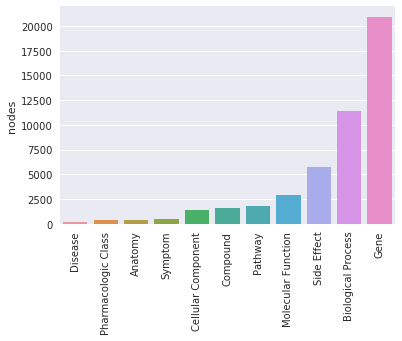

In [85]:
ax = seaborn.barplot(x='metanode', y='nodes', data=metanode_df.sort_values('nodes'))
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_xlabel(''); ax.set_ylabel('nodes');

/home/ubuntu/anaconda3/envs/integrate/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


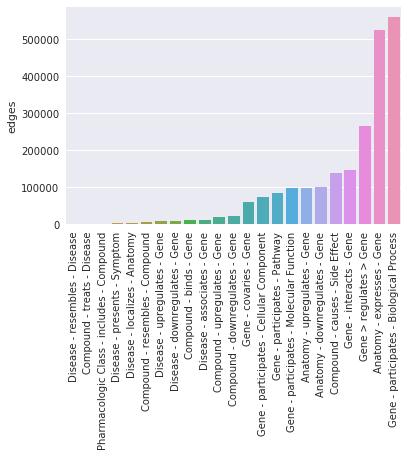

In [86]:
ax = seaborn.barplot(x='metaedge', y='edges', data=metaedge_df.sort_values('edges'))
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_xlabel(''); ax.set_ylabel('edges');

In [87]:
# print execution time
ends = datetime.datetime.now()
print('starts at: {}'.format(starts))
print('ends at: {}'.format(ends))
print("total time: {}".format(time.time() - start))

starts at: 2017-04-01 00:31:13.981152
ends at: 2017-04-01 00:44:36.302875
total time: 802.3218286037445
